In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

## help functions

In [2]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    
    return data

#feature extraction
def get_mean_window(df):
    return df.mean()

def get_min_window(df):
    return df.min()

def get_max_window(df):
    return df.max()

def get_std_window(df):
    return df.std()

def get_med_window(df):
    return df.median()

#TODO: scipy integrate
#TODO: voor elke as apart??
#measure of activity level (m/s²)
def get_signal_magnitude_area(df):
        sum = 0
        for i in range(0, len(df)):
            sum += (abs(df['x'].iloc[i]) + abs(df['y'].iloc[i]) + abs(df['z'].iloc[i]))
        return sum /len(df)
    #result = integrate.quad(lambda t: df['x'].apply(lambda n : abs(n)) + df['y'].apply(lambda n : abs(n)) + df['z'].apply(lambda n : abs(n)), 0, len(df))

#TODO: voor elke as apart??
#degree of movement intensity (m/s²)
def get_signal_magnitude_vector(df):
    sum = 0
    for i in range(0, len(df)):
        sum += math.sqrt(df['x'].iloc[i] * df['x'].iloc[i] + df['y'].iloc[i] * df['y'].iloc[i] + df['z'].iloc[i] * df['z'].iloc[i])
    return sum

#average angle (radian) between accelerometer vector and x as (parallel with arm)
def get_tilt_angle(df):
    df_cos = pd.DataFrame(columns=["tilt_ang"])
    df_dot = df['x']
    for i in range(0, len(df)):
        s = pd.Series({"tilt_ang" : (df_dot.iloc[i])/(math.sqrt(df['x'].iloc[i]*df['x'].iloc[i] + df['y'].iloc[i]*df['y'].iloc[i] + df['z'].iloc[i]*df['z'].iloc[i]))})
        df_cos=df_cos.append(s, ignore_index=True)
    df_angle = np.arccos(df_cos)
    return df_angle.mean()['tilt_ang']

def get_power_spectral_density(df):
    df_psd = np.abs(df)**2
    return df_psd.sum()

#TODO: datatype is object en niet compex nr
def get_entropy(df):
    entropy = []
    pdf = df / df.sum()
    for i in range (1, len(pdf.columns)):
        entropy.append(np.complex(-np.nansum(pdf.iloc[:,i] * np.log2(pdf.iloc[:,i]))))
    return entropy

#generate windows with 50% overlap
def windows(df, time, overlap):
    start = df.iloc[0]
    while  (start + pd.to_timedelta(time, unit='s')) < df.iloc[-1]:
        yield start, (start + pd.to_timedelta(time, unit='s'))
        if overlap:
            start += pd.to_timedelta(time/2, unit='s')
        else:
            start += pd.to_timedelta(time, unit='s')
    #last samples 
    yield (df.iloc[-1] - pd.to_timedelta(time, unit='s')), df.iloc[-1]
        
def feature_extraction_segmentation(data, window, overlap):
    column_names = ["x_mean", "y_mean", "z_mean", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max",
                "x_std", "y_std", "z_std", "x_med", "y_med", "z_med", "activity"]
    df = pd.DataFrame(columns = column_names)

    for (start, end) in windows(data['time'], window, overlap):
        vw1 = data['time'] >= start
        vw2 = data['time'] < end
        mean = get_mean_window(data[vw1 & vw2])
        min = get_min_window(data[vw1 & vw2])
        max = get_max_window(data[vw1 & vw2])
        std = get_std_window(data[vw1 & vw2])
        med = get_med_window(data[vw1 & vw2])
        sma = get_signal_magnitude_area(data[vw1 & vw2])
        smv = get_signal_magnitude_vector(data[vw1 & vw2])
        tilt = get_tilt_angle(data[vw1 & vw2])
        #fourrier transform
        t_x = data[vw1 & vw2][['time','x']].set_index('time')
        t_y = data[vw1 & vw2][['time','y']].set_index('time')
        t_z = data[vw1 & vw2][['time', 'z']].set_index('time')

        df_f = pd.DataFrame(columns=['f', 'x_f', 'y_f', 'z_f'])

    #TODO: determine sampling rate (datapoints per second)
        sampling_rate = 52

        df_f['x_f'] = FFT.fft(t_x).ravel()
        df_f['y_f'] = FFT.fft(t_y).ravel()
        df_f['z_f'] = FFT.fft(t_z).ravel()
        df_f['f'] = FFT.fftfreq(len(df_f['x_f'])) * sampling_rate

        psd = get_power_spectral_density(df_f)
        #entropy = get_entropy(df_f)

        df = df.append(pd.Series({'x_mean': mean['x'], 'y_mean': mean['y'], 'z_mean': mean['z'], "x_min" : min['x'],
                              "y_min" : min['y'], "z_min" : min['z'], "x_max" : max['x'], "y_max" : max['y'], "z_max" : max['z'],
                              "x_std" : std['x'], "y_std" : std['y'], "z_std" : std['z'], "x_med" : med['x'], "y_med" : med['y'], "z_med" : med['z'],
                              "sma" : sma, "smv" : smv, "tilt" : tilt, "x_psd" : psd['x_f'], "y_psd" : psd['y_f'], "z_psd" : psd['z_f']
                              , "activity" : data['activity'].iloc[0]}), ignore_index=True) # "x_entropy" : entropy[0], "y_entropy" : entropy[1], "z_entropy" : entropy[2],
    return df

#3 keer savgol filter uitvoeren met 33,5
def get_turns_smooth_side_swing(df):
    for i in range(0,5):
        df['x'] = savgol_filter(df[ 'x'].to_numpy(), 101, 5)
        df['y'] = savgol_filter(df[ 'y'].to_numpy(), 101, 5)
        df['z'] = savgol_filter(df[ 'z'].to_numpy(), 101, 5)
        df.plot(x='time', subplots=True)

    wx = find_peaks(df['x'])
    wy = find_peaks(df['y'])
    wz = find_peaks(df['z'])
    return (len(wx[0]) + len(wy[0]) + len(wz[0]))/3


column_names_org = ['time', 'x', 'y', 'z']

# preprocessing

In [3]:
jump_slow = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\jump_slow.csv", sep=';', header=0, skipinitialspace=True)
jump_fast = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\jump_fast.csv", sep=';', header=0, skipinitialspace=True)
side_swing = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\side_swing.csv", sep=';', header=0, skipinitialspace=True)
cross_over = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\cross_over.csv", sep=';', header=0, skipinitialspace=True)
forward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\forward_180_zonder_pauze.csv", sep=';', header=0, skipinitialspace=True)
backward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\backward_180_zonder_pauze.csv", sep=';', header=0, skipinitialspace=True)
#mistakes = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\mistakes.csv", sep=';', header=0, skipinitialspace=True)

## merge all activities

In [4]:
#zonder mistakes
shape = np.min([
    jump_slow.shape[0],
    jump_fast.shape[0],
    side_swing.shape[0],
    cross_over.shape[0],
    forward_180.shape[0],
    backward_180.shape[0]
])
shape

568

In [5]:
merged = pd.concat([
    shuffle(jump_slow).head(shape),
    shuffle(jump_fast).head(shape),
    shuffle(side_swing).head(shape),
    shuffle(cross_over).head(shape),
    shuffle(forward_180).head(shape),
    shuffle(backward_180).head(shape),
    #shuffle(mistakes).head(shape),
], ignore_index=True)
merged = merged.drop('Unnamed: 0', axis=1)
merged.shape

(3408, 22)

In [6]:
target = merged['activity']
merged.head()

,x_mean,y_mean,z_mean,x_min,y_min,z_min,x_max,y_max,z_max,x_std,...,x_med,y_med,z_med,activity,sma,smv,tilt,x_psd,y_psd,z_psd
0,-5.922987,-7.673078,-5.868421,-39.555752,-21.080767,-24.086153,21.571297,-0.978664,2.773281,10.970957,...,-3.333202,-5.541777,-4.845466,jump_slow,22.356611,714.610730,1.805334,7807.265595,4343.649853,3857.976882
1,5.912849,-9.219914,-0.183189,-8.733803,-28.362127,-11.282159,20.985054,1.799403,10.482956,7.813632,...,4.967500,-7.194021,-0.271585,jump_slow,20.824505,700.797050,1.285687,4931.707520,7550.755696,1255.658014
2,8.036893,-9.568161,-0.695391,-12.717853,-23.602802,-8.123632,23.148167,1.775474,6.594619,8.342095,...,9.815358,-8.907282,-0.314656,jump_slow,22.243081,770.208983,1.087924,6907.883348,6862.478435,727.075401
3,2.918821,-8.164874,-2.280782,-15.775880,-24.815964,-37.459637,39.804604,4.500899,5.845666,11.472031,...,1.768296,-5.034499,0.088534,jump_slow,21.117692,744.064015,1.238951,7014.870280,6522.780170,2870.884957
4,7.901238,-10.902252,-2.334521,-6.065805,-27.665815,-14.935999,23.897120,1.277767,10.135997,8.193512,...,6.654440,-11.054840,-2.495714,jump_slow,25.432023,836.809181,1.208242,6670.153028,9852.698857,2468.269936


## dimensionality reduction

In [7]:
pca = PCA(n_components=6)
merged = pd.DataFrame(pca.fit_transform(merged.drop('activity', axis=1)))
merged['activity'] = target
merged

,0,1,2,3,4,5,activity
0,1049.319480,3567.784295,-1256.319712,45.882084,-12.367848,-4.589007,jump_slow
1,-42.610504,-1319.001939,-1760.147894,19.367612,9.018460,0.107942,jump_slow
2,827.580018,-25.862552,-3253.519609,-41.121664,9.618083,-0.019301,jump_slow
3,1423.037529,1085.917538,-1484.917446,32.642091,13.503594,-18.868343,jump_slow
4,3001.964239,-1888.757999,-1295.560804,6.367792,12.437251,0.858089,jump_slow
...,...,...,...,...,...,...,...
3403,-3307.901026,-696.379983,-66.283101,-23.292366,9.624153,-0.125202,backward_180
3404,-776.665085,-1167.191546,-1171.589386,-11.174658,6.599019,-7.776435,backward_180
3405,1335.891348,1898.355141,-1520.714691,-13.950332,-24.595363,7.973335,backward_180
3406,1581.798389,4878.485953,-1084.944170,-57.150087,-10.558492,-6.804185,backward_180


## train-test split

In [8]:
#TODO: NIET NODIG!!!
#standardize
#scaler = preprocessing.StandardScaler().fit(df)
#df = pd.DataFrame(scaler.transform(df), columns=column_names[2:])

#label activity
le = preprocessing.LabelEncoder()
le.fit(merged['activity'])
merged['activity'] = le.transform(merged['activity'])
labels = le.inverse_transform([0,1,2,3,4,5])

#train test split
X_train, X_test, y_train, y_test = train_test_split(merged.drop('activity', axis=1), merged['activity'], test_size = 0.33, random_state = 42)

#normalize X
xNormalizer = preprocessing.Normalizer().fit(X_train)
X_train = xNormalizer.transform(X_train)
X_test = xNormalizer.transform(X_test)

# machine learning algorithms

## SVC

Training set score: 0.675
Test set score: 0.662


<IPython.core.display.Javascript object>


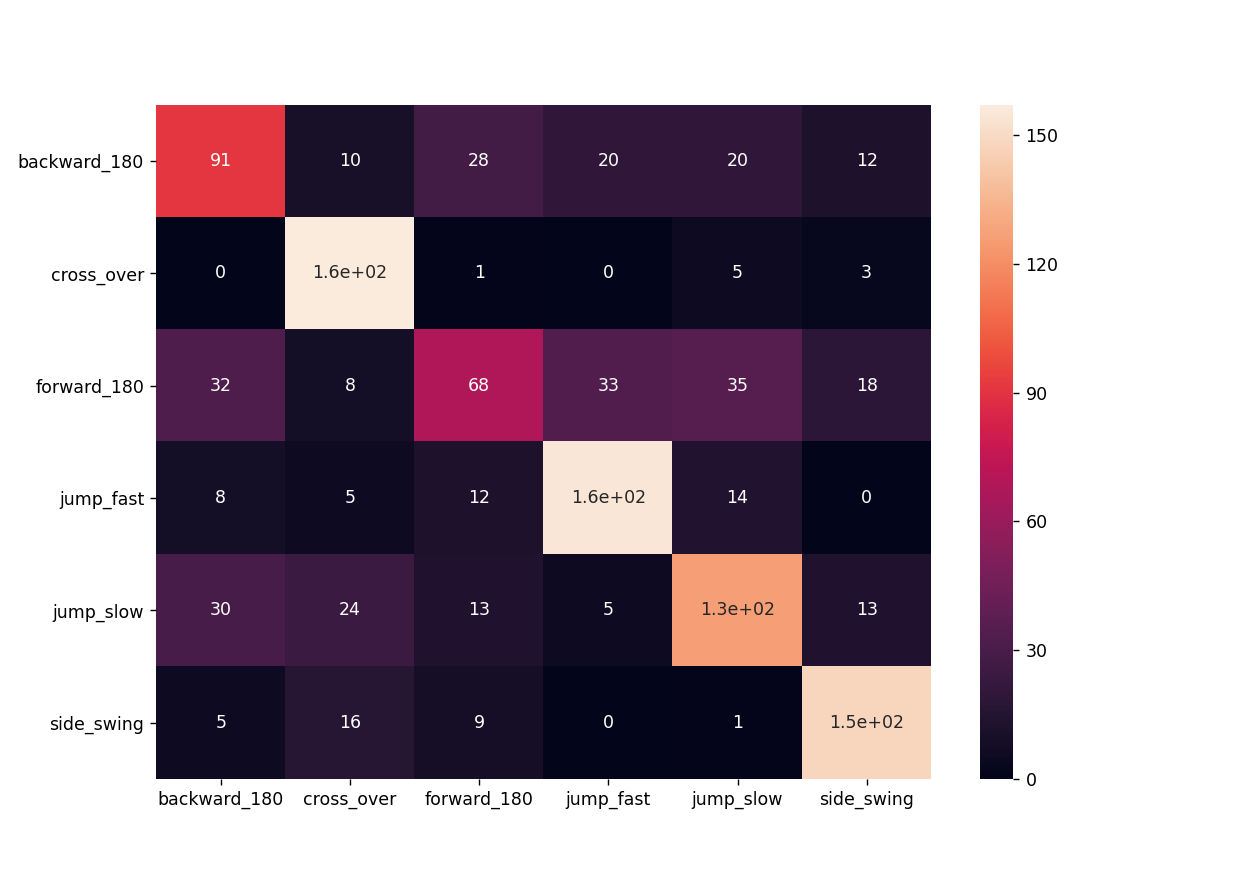

In [9]:
#hyperparameter tuning
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True) #verbose=2
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

In [25]:
y_pred = clf.predict(merged.drop('activity', axis=1).to_numpy())
cm = confusion_matrix( merged['activity'].to_numpy(), y_pred)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))

heatmap(cm, labels)

Training set score: 0.681
Test set score: 0.581


<IPython.core.display.Javascript object>

## linear SVC

Training set score: 0.615
Test set score: 0.604


<IPython.core.display.Javascript object>


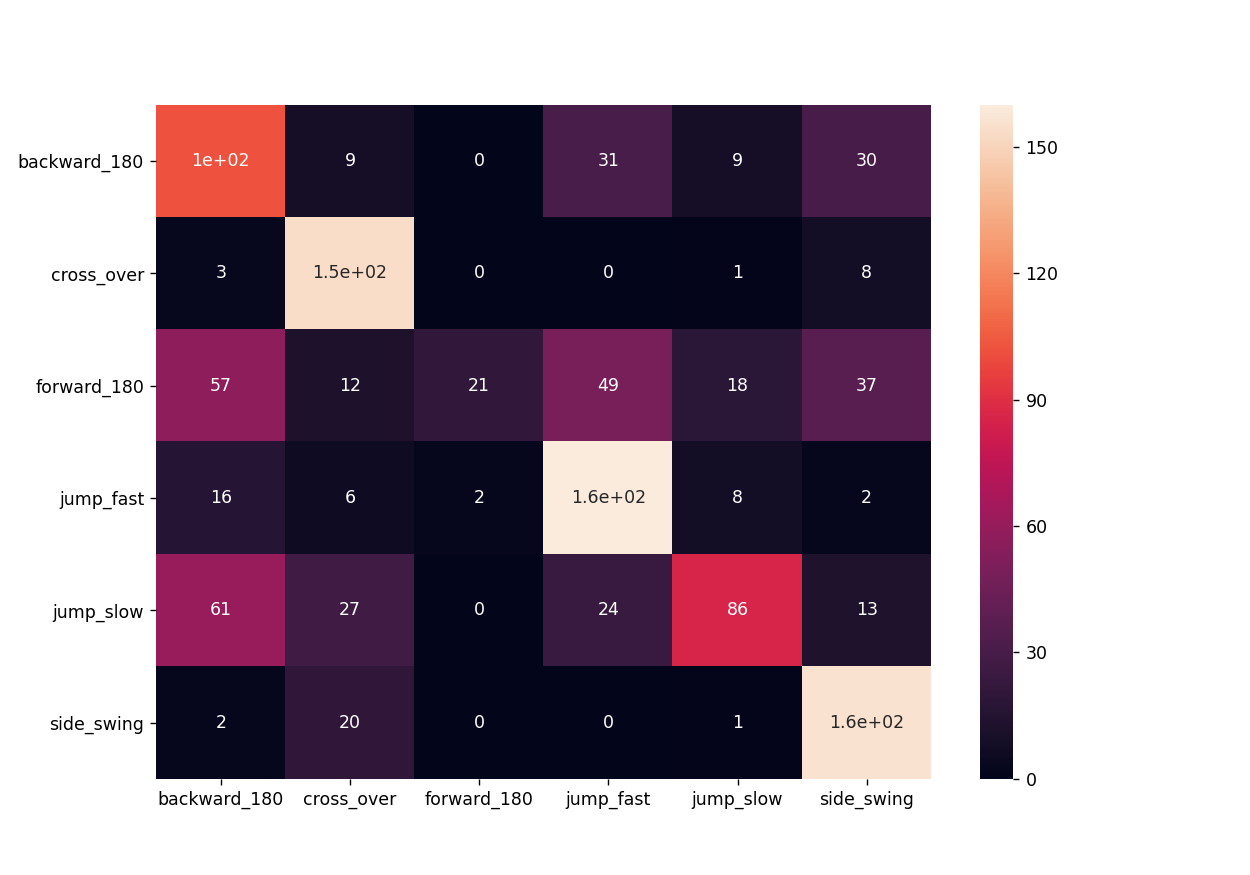

In [10]:
#hyperparameter tuning
param_grid = {'C': [0.1,1, 10, 100]}
grid = GridSearchCV(LinearSVC(),param_grid,refit=True)
grid.fit(X_train,y_train)

clf =  grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm,labels)

## random forest

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=   0.9s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ................................. n_estimators=100, total=   0.5s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   0.8s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=   6.0s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=   6.4s
[CV] n_estimators=1000 ...............................................
[CV] ................................ n_estimators=1000, total=   6.1s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.7s finished


Training set score: 1.000
Test set score: 0.746


<IPython.core.display.Javascript object>


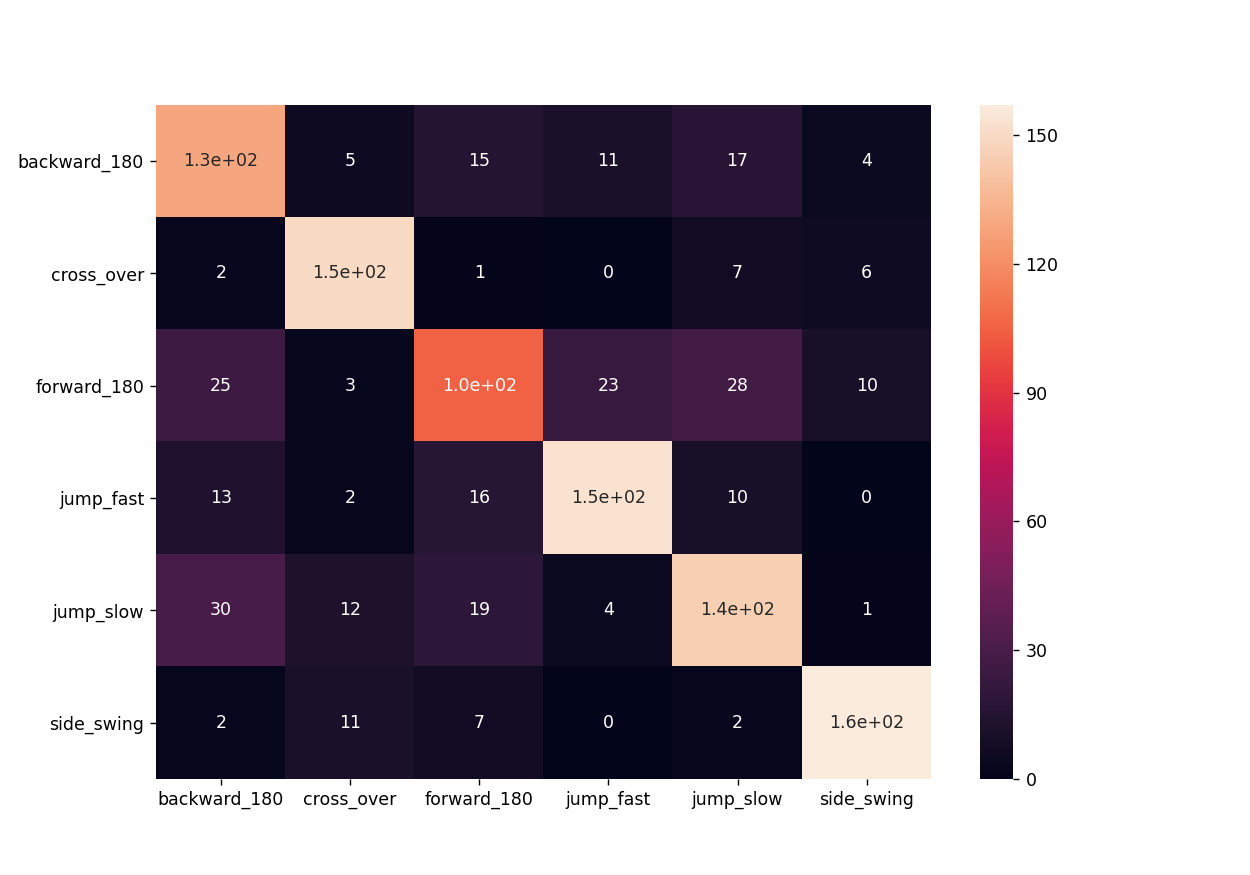

In [11]:
#hyperparameter tuning
param_grid = {'n_estimators': [100, 1000]}
             # 'max_depth': [10, 20],'min_samples_split': np.arange(0.10, 1, 0.4) ,
             # 'max_leaf_nodes': [10, 100, 1000, None]}
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## AdaBoost

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.1, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.1, n_estimators=10, total=   0.9s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_scor

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.1, n_estimators=10, total=   1.0s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_scor

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.1, n_estimators=1000, total= 1.3min
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_sc

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.30000000000000004, n_estimators=50, total=   4.3s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_job

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.5000000000000001, n_estimators=10, total=   0.6s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.5000000000000001, n_estimators=1000, total= 1.1min
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jo

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.7000000000000001, n_estimators=50, total=   3.2s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.9000000000000001, n_estimators=10, total=   0.8s
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs

[CV]  base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), learning_rate=0.9000000000000001, n_estimators=1000, total= 1.2min
[CV] base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jo

[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.1, n_estimators=100, total=   0.1s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=N

                     warm_start=False), learning_rate=0.30000000000000004, n_estimators=50, total=   0.0s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.30000000000000004, n_estimators=50 
[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weigh

[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.5000000000000001, n_estimators=10, total=   0.1s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, 

[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.5000000000000001, n_estimators=1000, total=   0.2s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False

                     warm_start=False), learning_rate=0.7000000000000001, n_estimators=100, total=   0.1s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.7000000000000001, n_estimators=1000 
[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weig

[CV]  base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False), learning_rate=0.9000000000000001, n_estimators=50, total=   0.1s
[CV] base_estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, 

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 21.6min finished


Training set score: 1.000
Test set score: 0.750


<IPython.core.display.Javascript object>


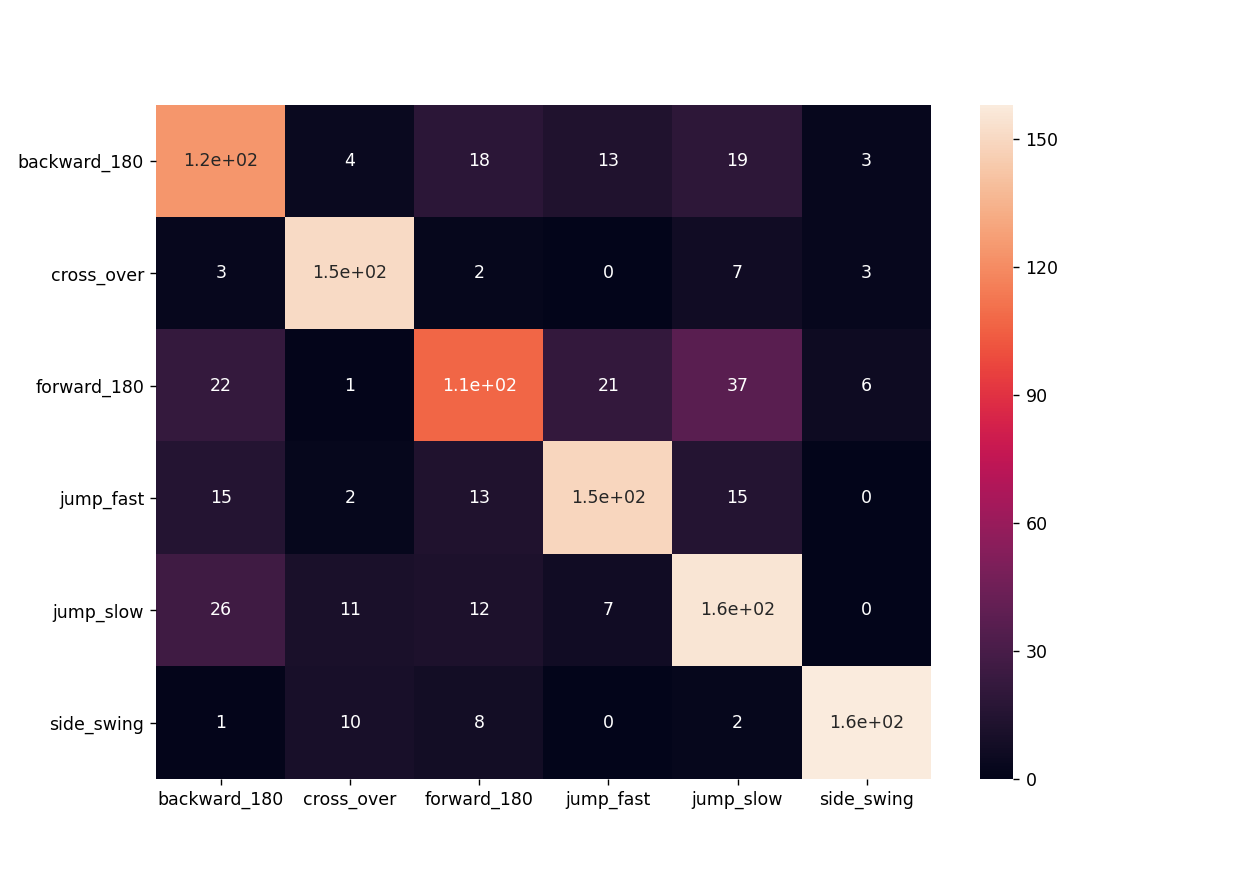

In [12]:
#hyperparameter tuning
param_grid = {'learning_rate': np.arange(0.10, 1, 0.2), 'n_estimators': [10, 50, 100, 1000],
              'base_estimator': [RandomForestClassifier(), ExtraTreesClassifier()]}
             # 'algorithm' : ['SAMME', 'SAMME.R']}
grid = GridSearchCV(AdaBoostClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## naive bayes

Training set score: 1.000
Test set score: 0.750


<IPython.core.display.Javascript object>


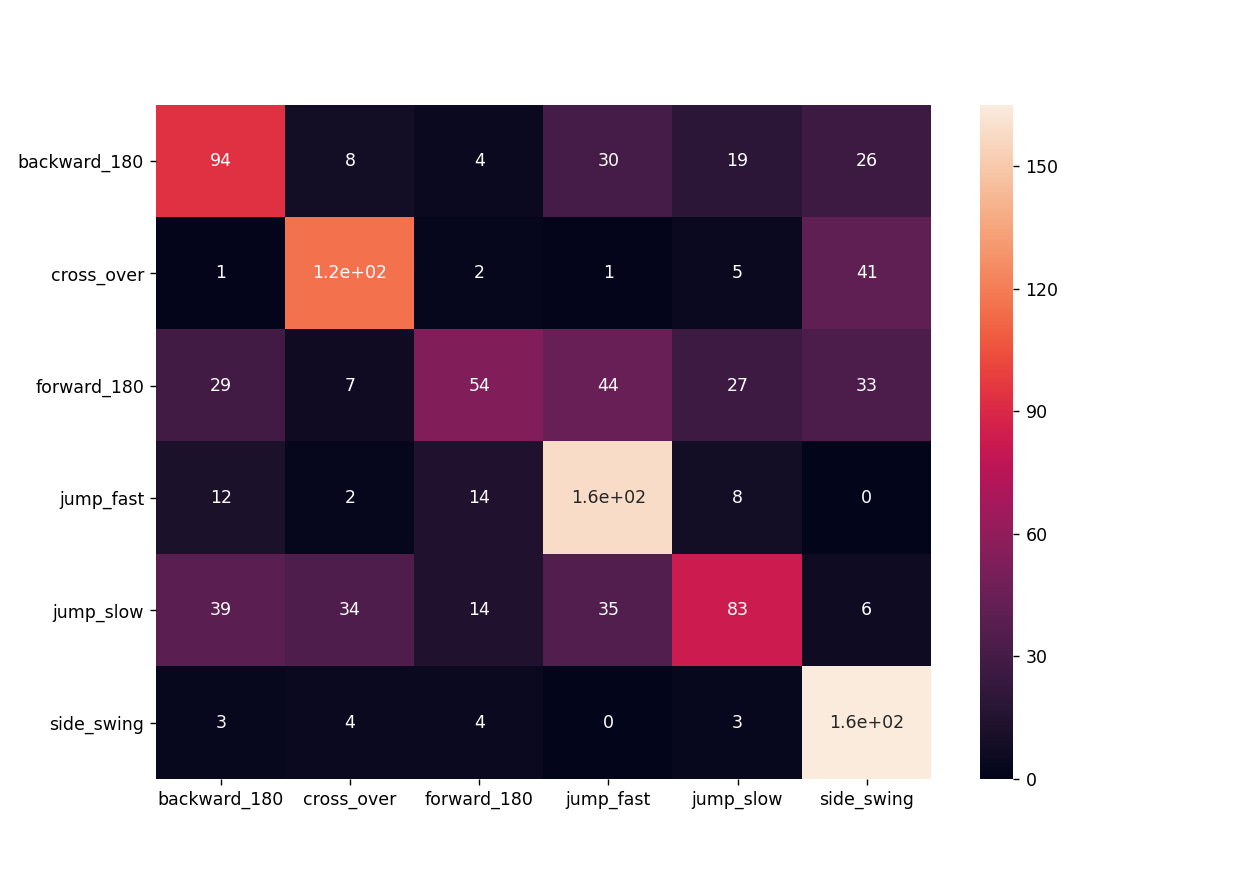

In [13]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## kneighbors 

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] algorithm=ball_tree, n_neighbors=1, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=1, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=1, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=2, weights=uniform .............
[

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=ball_tree, n_neighbors=2, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=2, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=2, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=4, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=4, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=4, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=4, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=4, weights=uniform .............
[CV]  algorithm=ball_tree, n_neighbors=4, weights=uniform, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=4, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=4, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=4, weights=distance ............
[CV]  algorithm=ball_tree, n_neighbors=4, weights=distance, total=   0.0s
[CV] algorithm=ball_tree, n_neighbors=4, weights=distance .

[CV] . algorithm=brute, n_neighbors=2, weights=distance, total=   0.0s
[CV] algorithm=brute, n_neighbors=2, weights=distance ................
[CV] . algorithm=brute, n_neighbors=2, weights=distance, total=   0.0s
[CV] algorithm=brute, n_neighbors=4, weights=uniform .................
[CV] .. algorithm=brute, n_neighbors=4, weights=uniform, total=   0.0s
[CV] algorithm=brute, n_neighbors=4, weights=uniform .................
[CV] .. algorithm=brute, n_neighbors=4, weights=uniform, total=   0.0s
[CV] algorithm=brute, n_neighbors=4, weights=uniform .................
[CV] .. algorithm=brute, n_neighbors=4, weights=uniform, total=   0.0s
[CV] algorithm=brute, n_neighbors=4, weights=distance ................
[CV] . algorithm=brute, n_neighbors=4, weights=distance, total=   0.0s
[CV] algorithm=brute, n_neighbors=4, weights=distance ................
[CV] . algorithm=brute, n_neighbors=4, weights=distance, total=   0.0s
[CV] algorithm=brute, n_neighbors=4, weights=distance ................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.7s finished


<IPython.core.display.Javascript object>


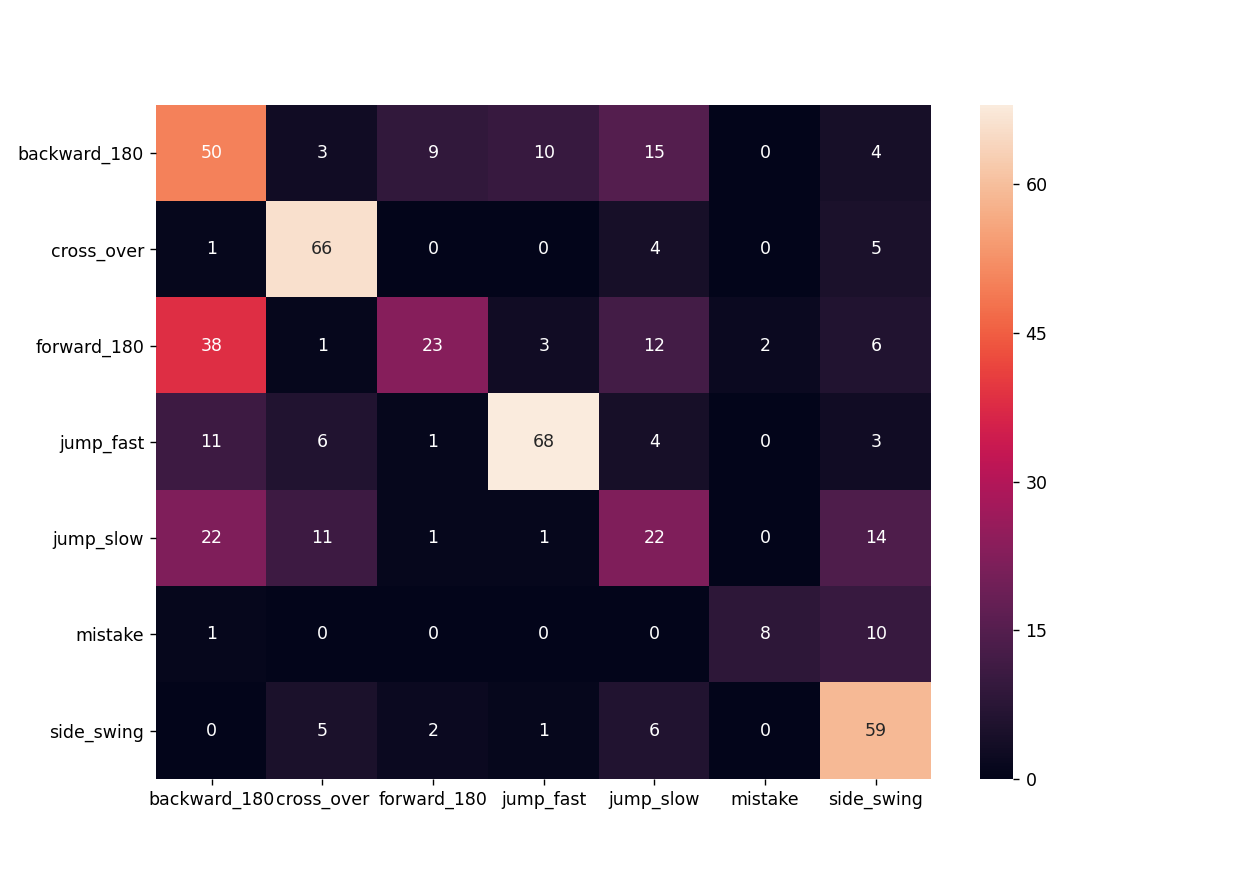

In [31]:
#hyperparameter tuning
param_grid = {'n_neighbors': [1,2,4,8,10], 'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}#, 'leaf_size': range(1,60,10), 
            #  'metric' : ['minkowski']}
grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## SGD classifier

Fitting 3 folds for each of 84 candidates, totalling 252 fits
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=constant, max_iter=100, shuffle=True 
[CV]  alpha

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True 
[CV]  alpha=1e-07, eta0=1, learning_rate=optimal, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=1e-07, eta0=1, learning_rate=invscaling, max_i

[CV]  alpha=1e-06, eta0=1, learning_rate=invscaling, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=invscaling, max_iter=1000, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=invscaling, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True 
[CV]  alpha=1e-06, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=1e-06, eta0=1, learning_rate=adaptive,

[CV]  alpha=0.0001, eta0=1, learning_rate=constant, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=constant, max_iter=1000, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=constant, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True 
[CV]  alpha=0.0001, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=0.0001, eta0=1, learning_rate=optimal, ma

[CV] alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True 
[CV]  alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True 
[CV]  alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True 
[CV]  alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True 
[CV]  alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True 
[CV]  alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=True 
[CV]  alpha=0.001, eta0=1, learning_rate=adaptive, max_iter=100, shuffle=

[CV]  alpha=0.1, eta0=1, learning_rate=constant, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=constant, max_iter=1000, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=constant, max_iter=1000, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=10, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True 
[CV]  alpha=0.1, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True, total=   0.0s
[CV] alpha=0.1, eta0=1, learning_rate=optimal, max_iter=100, shuffle=True 
[CV]  alph

[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:    5.6s finished


<IPython.core.display.Javascript object>


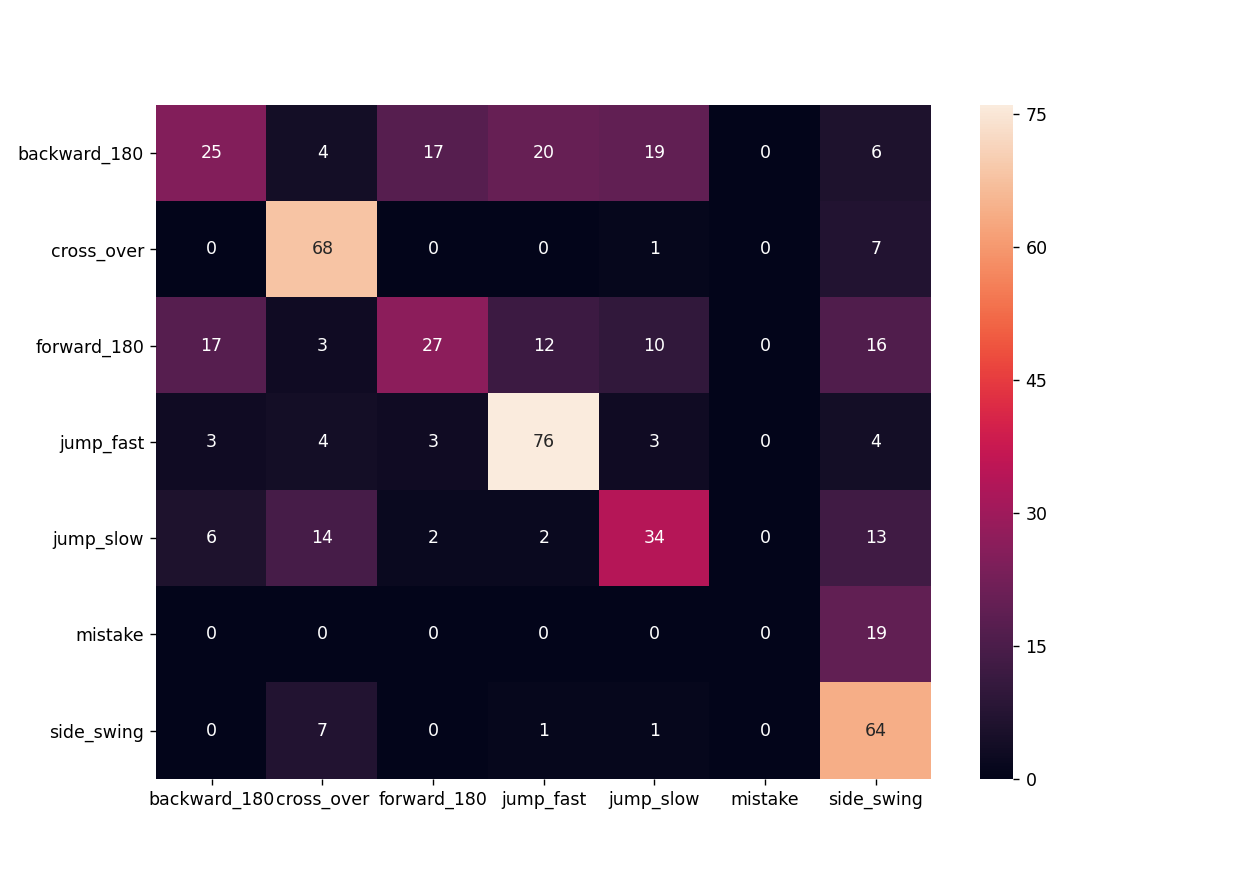

In [32]:
#hyperparameter tuning
param_grid = {'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 
              'max_iter': [10, 100, 1000], #np.ceil(10**6 / n) 
             'shuffle' : [True], 'eta0' : [1]}
grid = GridSearchCV(SGDClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm,labels)

## MLP classifier

Training set score: 0.621
Test set score: 0.553


<IPython.core.display.Javascript object>


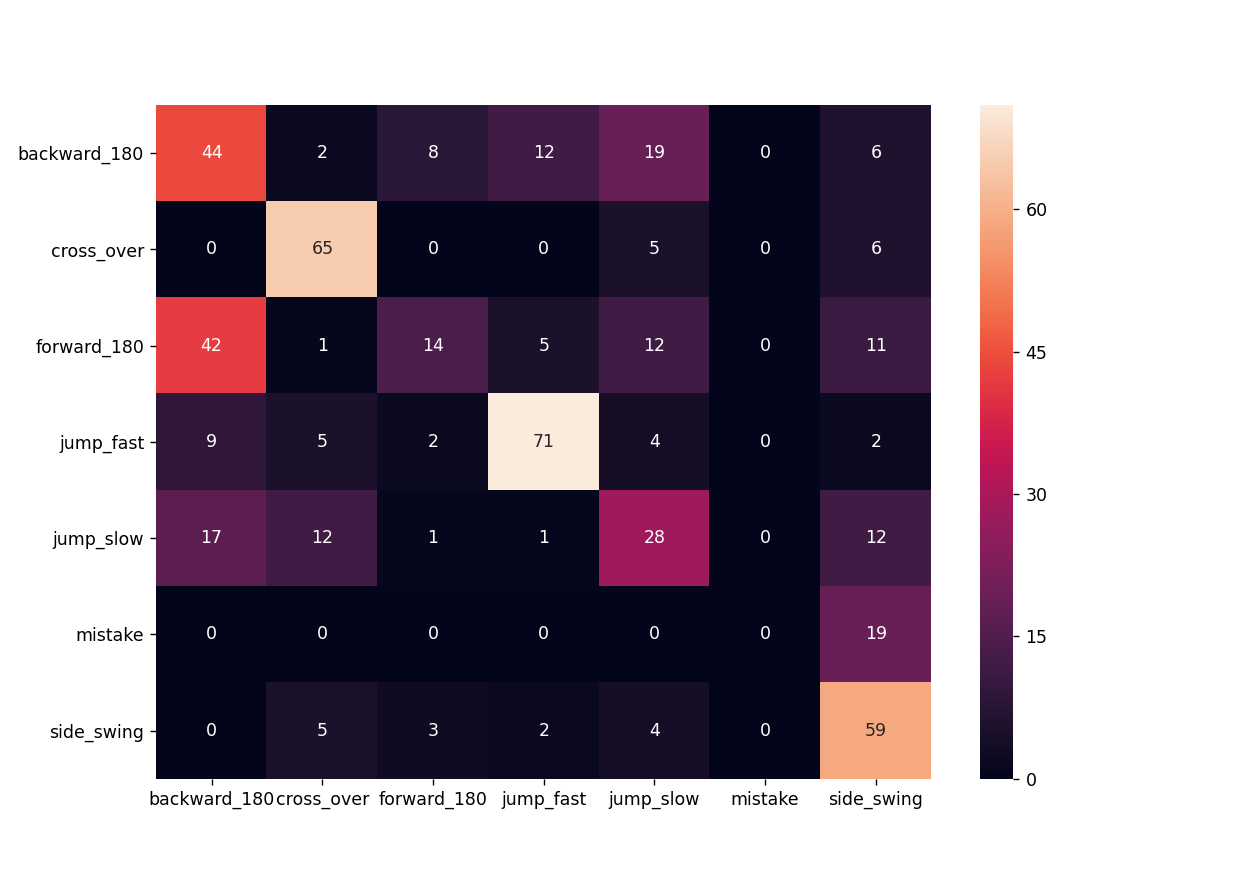

In [33]:
#hyperparameter tuning
#param_grid = {'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
   # 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], #'activation': ['identity', 'logistic','tanh', 'relu'],
    #'learning_rate': ['invscaling', 'constant','adaptive']}
#grid = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=2)
#grid.fit(X_train,y_train)

#clf = grid.best_estimator_
clf=MLPClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Training set score: {:.3f}".format(clf.score(X_train,y_train)))
print("Test set score: {:.3f}".format(clf.score(X_test,y_test)))
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

# save model

In [53]:
filename = 'rope_skipping_model.sav'
joblib.dump(clf, filename)

['rope_skipping_model.sav']

In [54]:
filename = 'rope_skipping_label_encoder.plk'
joblib.dump(le, filename)

['rope_skipping_label_encoder.plk']